In [1]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive')

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/Radar/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
# FOLDERNAME = os.getcwd()+'/'
print('FOLDERNAME=' + FOLDERNAME)
#
import numpy as np
import tensorflow as tf
import csv
#
from pathlib import Path
import argparse
import json
#
import sys
sys.path.append(FOLDERNAME+'scripts/')
#
from data_lab import *
from utils import *
from models import *
from metrics import *
from plot_tools import *

#########################################################################################
################################## READ JSON EXP FILE ###################################
#########################################################################################
# parser = argparse.ArgumentParser()
# parser.add_argument('param_file', type=Path)
# args = parser.parse_args()
# param = json.load(args.param_file.open())



FOLDERNAME=/content/drive/My Drive/CS231N/Project/RainfallNowcasting/Radar/


In [3]:
!pip install cfgrib
!sudo apt-get install libeccodes0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libeccodes0 is already the newest version (2.6.0-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
param = {}
param['nom_test'] = 'nom_test'
param['new_size'] = 128
param['batch_size'] = 2
param['nb_epochs'] = 2
param['loss'] = 'masked_logcosh'
param['learning_rate'] = 1e-4
param['nb_filters'] = 5
param['filter_size'] = 64
param['last_filter_size'] = 1
param['activation'] = 'relu'
param['weights_initialization'] = 'he_normal'
param['years'] = [2017]
param['months'] = [5]
param['parts_month'] = [3]
param['input_timeframes'] = 10
param['output_timeframes'] = 5
param['overlapping'] = 0
param['reflectivity_on'] = 0
param['quality_on'] = 0
param['lsm_on'] = 1
param['relief_on'] = 1
param['temperature_on'] = 1
param['dew_temp_on'] = 1
param['humidity_on'] = 1
param['wind_speed_on'] = 1
param['wind_dir_on'] = 1
param['wind_comp_on'] =1
param['pressure_on'] = 1
param['precip_on']= 1

## New parameters
param['threshold_rain_in_regions'] = 100
param['size_regions'] = 64

In [0]:
#########################################################################################
################################## EXPERIMENT FEATURES ##################################
#########################################################################################
nom_test = param['nom_test']                        # NAME OF THE CURRENT TEST
archi = nom_test.split('_')[0]                              # NETWORK ARCHITECTURE
new_size = [param['new_size'],param['new_size']]    # SIZE DATA (None = keep initial size)
bs = param['batch_size']                            # BATCH SIZE
ep = param['nb_epochs']                             # NB EPOCHS


#########################################################################################
#################################### NETWORK FEATURES ###################################
#########################################################################################
loss = param['loss']
if loss=='masked_logcosh':
    loss=masked_logcosh
elif loss=='masked_mae':
    loss=masked_mae
elif loss=='masked_mse':
    loss=masked_mse
optimizer = tf.keras.optimizers.Adam(lr=param['learning_rate'])
nk = param['nb_filters']
ks = param['filter_size']
lks = param['last_filter_size']
activ = param['activation']
init = param['weights_initialization']


#########################################################################################
################################## CALLBACKS & METRICS ##################################
#########################################################################################
csv_logger = tf.keras.callbacks.CSVLogger('models/'+archi+'_'+nom_test+'_train.csv')
term_nan = tf.keras.callbacks.TerminateOnNaN()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_masked_BMW', patience=5, mode='max', restore_best_weights=True)
callbacks_list = [term_nan, csv_logger, early_stopping]
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_masked_BMW', patience=4, factor=0.5, mode='max')
#callbacks_list = [term_nan, reduce_lr, csv_logger, early_stopping]
#
metrics_list = [masked_acc, masked_ssim, masked_psnr, masked_cor, masked_prec, masked_recall, masked_BMW]


#########################################################################################
#################################### GLOBAL FEATURES ####################################
#########################################################################################
zone = "NW"                           # NW, SE
years = param['years']                # 2016, 2017, 2018
months = param['months']              # 1..12
parts_month = param['parts_month']    # 1,2,3 (each month is divided in 3 parts)
input_timeframes = param['input_timeframes']                   # how many timeframes for input
output_timeframes = param['output_timeframes']                 # how many timeframes for output
overlapping_data = param['overlapping']                        # data overlap in time (= 1) or not (= 0)
fraction_test = 0.1                   # fraction of test data
rainfall_threshold_value = 40.        # Value above which values are considered to be one


#########################################################################################
################################## ADDITIONAL FEATURES ##################################
#########################################################################################
features_bool = {'reflectivity': param['reflectivity_on'],
                 'rainfall quality': param['quality_on'],
                 'land sea': param['lsm_on'],
                 'elevation': param['relief_on']}
features_max_threshold = {'reflectivity': 60,
                          'rainfall quality': 100,
                          'land sea': 1,
                          'elevation': 629}
features_min_threshold = {'reflectivity': 0,
                          'rainfall quality': 0,
                          'land sea': 0,
                          'elevation': 0}
#
wf_model = 'arpege' # None for no model, otherwise arpege
weather_model_bool = {'temperature': param['temperature_on'],
                      'dew point temperature' : param['dew_temp_on'],
                      'humidity': param['humidity_on'],
                      'wind speed': param['wind_speed_on'],
                      'wind directions': param['wind_dir_on'],
                      'wind components': param['wind_comp_on'],
                      'pressure': param['pressure_on'],
                      'precipitation': param['precip_on']}
weather_model_max_threshold = {'temperature': 308,
                               'dew point temperature' : 308,
                               'humidity': 100,
                               'wind speed': 30,
                               'wind directions': 360,
                               'wind components': 30,
                               'pressure': 105000,
                               'precipitation': rainfall_threshold_value}
weather_model_min_threshold = {'temperature': 268,
                               'dew point temperature' : 268,
                               'humidity': 0,
                               'wind speed': 0,
                               'wind directions': 0,
                               'wind components': -30,
                               'pressure': 96000,
                               'precipitation': 0}

## New parameters
threshold_rain_in_regions = param['threshold_rain_in_regions']
size_regions = param['size_regions']

#########################################################################################
#########################################################################################
#########################################################################################



In [0]:
#########################################################################################
####################################### MAKE DATA #######################################
#########################################################################################
data_dir = FOLDERNAME+'MeteoNet/'
X, y, features_list = get_data_and_features(data_dir, zone, years, months, parts_month,
                                            new_size, input_timeframes, output_timeframes,
                                            rainfall_threshold_value,
                                            features_bool, weather_model_bool, wf_model,
                                            weather_model_max_threshold, weather_model_min_threshold,
                                            features_max_threshold, features_min_threshold,
                                            overlapping_data, threshold_rain_in_regions, 
                                            size_regions)
print('X shape = ({0}, {1}, {2}, {3}, {4})'.format(X.shape[0],X.shape[1],X.shape[2],X.shape[3],X.shape[4]))
print('y shape = ({0}, {1}, {2}, {3}, {4})'.format(y.shape[0],y.shape[1],y.shape[2],y.shape[3],y.shape[4]))
print('Additional features: [%s]' % ', '.join(features_list))
X, y, X_test, y_test = split_train_test(fraction_test, X, y)
print('X_train shape = ({0}, {1}, {2}, {3}, {4})'.format(X.shape[0],X.shape[1],X.shape[2],X.shape[3],X.shape[4]))
print('y_train shape = ({0}, {1}, {2}, {3}, {4})'.format(y.shape[0],y.shape[1],y.shape[2],y.shape[3],y.shape[4]))
print('X_test shape = ({0}, {1}, {2}, {3}, {4})'.format(X_test.shape[0],X_test.shape[1],X_test.shape[2],X_test.shape[3],X_test.shape[4]))
print('y_test shape = ({0}, {1}, {2}, {3}, {4})'.format(y_test.shape[0],y_test.shape[1],y_test.shape[2],y_test.shape[3],y_test.shape[4]))
if archi=='ddnet':
    X_content = get_content_data(X)
    X_content_test = get_content_data(X_test)
N, T, H, W, C = X.shape





Year: 2017 Month: 5 Part of the month: 3, Done !
Got rainfall
Got land sea
Got elevation
2017-05-21 00:00:00
2017-05-22 00:00:00
2017-05-26 00:00:00
2017-05-27 00:00:00
2017-05-28 00:00:00
2017-05-29 00:00:00
2017-05-30 00:00:00
2017-05-31 00:00:00
2m


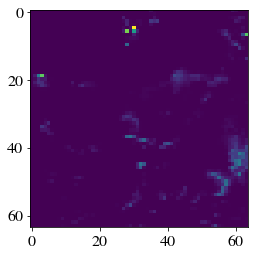

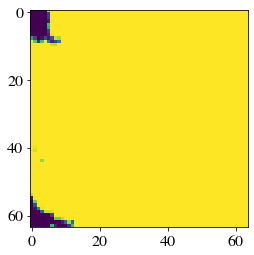

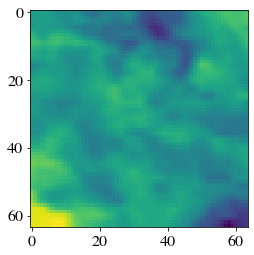

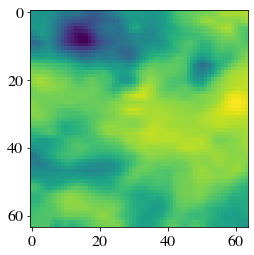

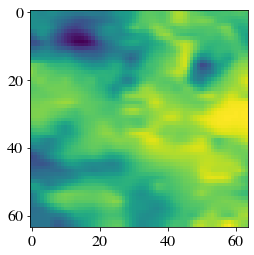

In [18]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import colors
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

n = 306
t = 3
plt.imshow(X[n,t,:,:,0])
plt.show()
plt.imshow(X[n,t,:,:,1])
plt.show()
plt.imshow(X[n,t,:,:,3])
plt.show()
plt.imshow(X[n,t,:,:,4])
plt.show()
plt.imshow(X[n,t,:,:,5])
plt.show()

In [0]:
#########################################################################################
###################################### INIT MODEL #######################################
#########################################################################################
if archi=='convdlrm':
    model = convdlrm_init(H, W, C, output_timeframes, nk, ks, lks, activ, init)
elif archi=='ddnet':
    model = ddnet_init(H, W, C, output_timeframes, nk, ks, lks, activ, init)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics_list)

#########################################################################################
####################################### RUN MODEL #######################################
#########################################################################################
if archi=='convdlrm':
    history = model.fit(X, y,
                        batch_size=bs,
                        epochs=ep,
                        callbacks=callbacks_list,
                        validation_split=0.1)
    results = model.evaluate(X_test, y_test, batch_size=bs, return_dict=True)
elif archi=='ddnet':
    history = model.fit([X, X_content], y,
                        batch_size=bs,
                        epochs=ep,
                        callbacks=callbacks_list,
                        validation_split=0.1)
    results = model.evaluate([X_test, X_content_test], y_test, batch_size=bs, return_dict=True)


#########################################################################################
###################################### SAVE MODEL #######################################
#########################################################################################
model.save('models/'+nom_test+'.h5')
with open('models/'+nom_test+'_test.csv', 'w') as f:
    w = csv.DictWriter(f, results.keys())
    w.writeheader()
    w.writerow(results)



#########################################################################################
######################################### PLOT ##########################################
#########################################################################################
# 1- History
foldername = FOLDERNAME+'plots/'
plot_history(history, results, nom_test, save=True, foldername=foldername)

# 2- Train Example
itest = np.argmax(np.sum(X[:,:,:,:,0], axis=(1,2,3)))
track = tf.expand_dims(X[itest,:,:,:,0], axis=-1)
true_track = np.concatenate((track, y[itest]), axis=0)
if archi == 'convdlrm':
    track = np.concatenate((track[None,:,:,:,:], model.predict(X[itest][None,:,:,:,:])), axis=1)
elif archi == 'ddnet':
    track_m = X[itest]
    track_c = X_content[itest]
    track = np.concatenate((track[None,:,:,:,:], model.predict([track_m[None,:,:,:,:], track_c[None,:,:,:]])), axis=1)
lat, lon = get_coords(data_dir, zone)
plot_track(true_track, track, rainfall_threshold_value,
           size_regions, input_timeframes, output_timeframes,
           lat, lon, nom_test, tag='train',
           save=True, foldername=foldername)

# 3- Test Example
itest = np.argmax(np.sum(X_test[:,:,:,:,0], axis=(1,2,3)))
track = tf.expand_dims(X_test[itest,:,:,:,0], axis=-1)
true_track = np.concatenate((track, y_test[itest]), axis=0)
if archi == 'convdlrm':
    track = np.concatenate((track[None,:,:,:,:], model.predict(X_test[itest][None,:,:,:,:])), axis=1)
elif archi == 'ddnet':
    track_m = X_test[itest]
    track_c = X_content_test[itest]
    track = np.concatenate((track[None,:,:,:,:], model.predict([track_m[None,:,:,:,:], track_c[None,:,:,:]])), axis=1)
lat, lon = get_coords(data_dir, zone)
plot_track(true_track, track, rainfall_threshold_value,
           size_regions, input_timeframes, output_timeframes,
           lat, lon, nom_test, tag='test',
           save=True, foldername=foldername)

